In [223]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Fourth approach

Intractable to work with the complete data set at any stage (including while calling CNVRs). Low-rank representation to use in CPD? Graphical approach?

## Third approach

Let $\mathbf{X}$ be a n x p matrix of observations of rainfall on each site, $n$ for $n=1, 2, ..., N$, at each day, $p$ for $p=1, 2, ..., P$. We expect rainfall to vary only by site, not by day. We do not have data for every site on every day; instead, we have $i$ observations of $k$ sites, a contiguous subset of the $N$ total sites, on a given day, $p$.

Use python to probabilistically estimate the rainfall at each site. Begin with the following simulated data:
```
import numpy as np

N = 100
P = 200
rng = np.random.default_rng()
true_rainfall = rng.standard_normal(N)

K = np.argmax(rng.multinomial(1, np.ones(N)/N, size=(P, 2)), axis=2)
K = np.sort(K, axis=1)

X = np.zeros((P, N))
for i in range(P):
    epsilon_i = rng.standard_normal(np.diff(K[i]))
    X[i, K[i][0]:K[i][1]] = true_rainfall[K[i][0]:K[i][1]] + epsilon_i
```

Attempt a very general approach.

$$
\begin{gather*}
  X_l \sim \mathcal{N}(\mu_l, 1)
\end{gather*}
$$

In [365]:
import numpy as np

N = 100
P = 200
rng = np.random.default_rng()
true_rainfall = rng.standard_normal(N)

K = np.argmax(rng.multinomial(1, np.ones(N)/N, size=(P, 2)), axis=2)
K = np.sort(K, axis=1)

X = np.zeros((P, N))
for i in range(P):
    epsilon_i = rng.standard_normal(np.diff(K[i]))
    X[i, K[i][0]:K[i][1]] = true_rainfall[K[i][0]:K[i][1]] + epsilon_i

<Axes: >

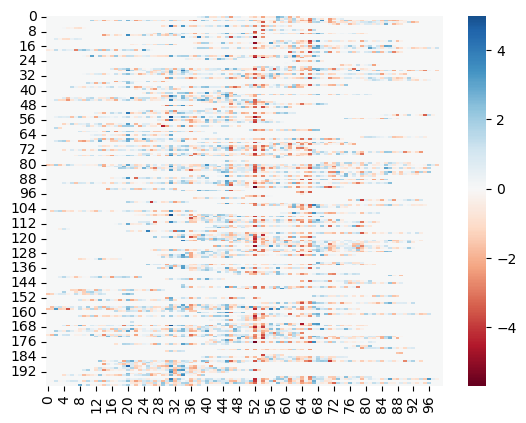

In [368]:
sns.heatmap(X, cmap="RdBu", center=0)

## Second approach

In [286]:
# TODO: Add another latent level of lower dimension than L to control k_probs

import numpy as np

def step(x, k, random_state=None, transition_prob=np.ones(3)/3):
    rng = np.random.default_rng(random_state)
    n_obs, __ = x.shape
    c = rng.choice([-1, 0, 1], p=transition_prob, size=n_obs)
    
    x_step = x.copy()
    x_step[:, k[0]:k[1]] = x_step[:, k[0]:k[1]] + c[..., None]
    
    return x_step

def k_probs_inference(data):
    # TODO: Implement
    ...
    
rng = np.random.default_rng()
N = 20
L = 100
T = 100
P = [0.1, 0.8, 0.1]
J = 10
I = 5

# init
X = np.zeros((N, L))
alpha = np.ones(L)
k_probs = rng.dirichlet(alpha, size=1)
K = np.argmax(rng.multinomial(1, k_probs, size=(T, 2)), axis=2)
K = np.sort(K, axis=1)

# simulate
X_t = X.copy()
for k_t in K:
    X_t = step(X_t, k_t, transition_prob=P)
    
# simulate observations
obs_sites_start = rng.integers(0, L-I, size=(N, J))
X_t_obs = np.zeros((N, J, 2))
for i in range(N):
    for j in range(J):
        X_t_obs[i, j, 0] = obs_sites_start[i][j]
        X_t_obs[i, j, 1] = X_t[i, obs_sites_start[i][j]:obs_sites_start[i][j]+I].mean()

data = (
    pd.concat([
        pd.DataFrame(X_t_obs[:, :, ix],
                     index=pd.Index(np.arange(N), name="sample"),
                     columns=pd.Index(np.arange(J), name="site"))
        .stack()
        .rename(col)

        for col, ix in zip(["start", "value"], range(2))
    ], axis=1)
    .reset_index()
    .eval("end = start + @I")
)

k_probs_pred = k_probs_inference(data)

<Axes: >

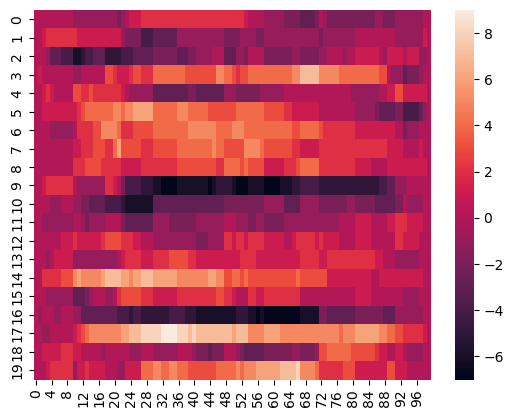

In [328]:
sns.heatmap(X_t)

In [342]:
# TODO: Add another latent level of lower dimension than L to control k_probs

import numpy as np

def step(
    x,
    k,
    random_state=None,
    transition_prob=np.ones(3)/3,
):
    rng = np.random.default_rng(random_state)
    n_obs, __ = x.shape
    if transition_prob is None:
        # Approximate from normal
        c = rng.standard_normal(size=n_obs)
    elif isinstance(transition_prob, np.ndarray):
        c = rng.choice([-1, 0, 1], p=transition_prob, size=n_obs)
    elif isinstance(transition_prob, float):
        c = rng.normal(0, transition_prob, size=n_obs)
    
    x_step = x.copy()
    x_step[:, k[0]:k[1]] = x_step[:, k[0]:k[1]] + c[..., None]
    
    return x_step

def sim_transition_probs():
    # TODO: Implement
    pass

def k_probs_inference(data):
    # TODO: Implement
    pass
    
rng = np.random.default_rng()
N = 200
L = 1000
T = 100
# P = [0.1, 0.8, 0.1]
P = .1
J = 10
I = 5

# init
X = np.zeros((N, L))
alpha = np.ones(L)
k_probs = rng.dirichlet(alpha, size=1)
K = np.argmax(rng.multinomial(1, k_probs, size=(T, 2)), axis=2)
K = np.sort(K, axis=1)

# simulate
X_t = X.copy()
for k_t in K:
    X_t = step(X_t, k_t, transition_prob=P)
    
# simulate observations
obs_sites_start = rng.integers(0, L-I, size=(N, J))
X_t_obs = np.zeros((N, J, 2))
for i in range(N):
    for j in range(J):
        X_t_obs[i, j, 0] = obs_sites_start[i][j]
        X_t_obs[i, j, 1] = X_t[i, obs_sites_start[i][j]:obs_sites_start[i][j]+I].mean()

data = (
    pd.concat([
        pd.DataFrame(X_t_obs[:, :, ix],
                    index=pd.Index(np.arange(N), name="sample"),
                    columns=pd.Index(np.arange(J), name="site"))
        .stack()
        .rename(col)

        for col, ix in zip(["start", "value"], range(2))
    ], axis=1)
    .reset_index()
    .eval("end = start + @I")
)

k_probs_pred = k_probs_inference(data)

<Axes: >

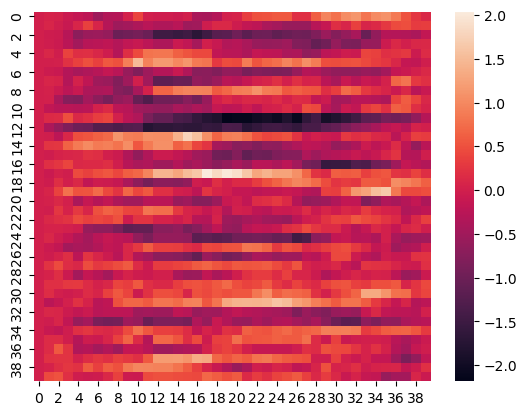

In [348]:
sns.heatmap(X_t[::5, ::25])

## First approach

There is an ordered series of sites indexed by $i$ for $i=0,1,...,20000$. At each site there is a bucket to catch rainwater. The sites are partially observed by $n$ observers. Using python, we can simulate what some of the resulting data may look like:
```
from collections import namedtuple
Site = namedtuple('Site', ['country', 'field', 'start', 'end', 'rainwater'])
observer_1 = Site('country1', 'field1', 100, 2000, 0.92)
observer_2 = Site('country1', 'field1', 1800, 20000, 1.3)
observer_3 = Site('country1', 'field1', 1000, 5000, 1.05)
# ...
# observer_n = ...
```
Write code to return the amount of `rainwater` at each of $i$ sites. When there are multiple observations for a site, take their average. When there are no observations for a site, use constant extrapolation to fill in the values on either side of the missing tract of sites.

Use python and efficient object types and performant code such that the approach scales to billions of sites and thousands of observers.

Let's imagine we're dealing with enormous fields, such that in a single field there will be multiple "microclimates" typified by different rainfall amounts. Let $Y$ be the amount of rainwater in a bucket, $i$ the site index, $X_i$ the microclimate of the $i$th bucket, and $n$ the observer index. $Y$ is influenced by not only $X$ but also observations error and a spatial autocorrelation among adjacent buckets (due to the gradual nature of microclimate transitions, from one microclimate to the next).

Write a python program to predict the start, end, and average rainfall for each microclimate per the following specifications:
- The microclimates are unobserved and there is an unknown number, $c$, of them
- Microclimates cannot overlap

The data you have available are the same as above:
```
from collections import namedtuple
Site = namedtuple('Site', ['country', 'field', 'start', 'end', 'rainwater'])
observer_1 = Site('country1', 'field1', 100, 2000, 0.92)
observer_2 = Site('country1', 'field1', 1800, 20000, 1.3)
observer_3 = Site('country1', 'field1', 1000, 5000, 1.05)
# ...
# observer_n = ...
```

Please consider the following general strategy when providing and answer:

binned_site_rainwater_data, binned_site_ids <-- bin_site_data(observed_rainwater_data, site_ids, granularity/coarseness)
true_rainwater_data <-- observation_process(binned_site_rainwater_data, binned_site_ids, observer_ids)
cps <-- changepoint_detection(true_rainwater_data)
microclimate_locations <-- data_parsing(cps, true_rainwater_data, site_ids)

Please consider the following model and revise your answer:

binned_site_rainwater_data, binned_site_ids <-- bin_site_data(observed_rainwater_data, site_ids, granularity/coarseness)
true_rainwater_data <-- observation_process(binned_site_rainwater_data, binned_site_ids, observer_ids)
cps <-- changepoint_detection(true_rainwater_data)
microclimate_locations <-- data_parsing(cps, true_rainwater_data, site_ids)

In [14]:
import numpy as np

# Define parameters
n = 100
l = 10

# Generate arrays
arr_idx = np.arange(n)
arr = np.random.normal(0, 1, n)

# Compute number of bins
num_bins = n // l

# Reshape arr_idx and arr into a 2D array of shape (num_bins, l)
arr_idx_2d = arr_idx[:num_bins * l].reshape((num_bins, l))
arr_2d = arr[:num_bins * l].reshape((num_bins, l))

# Compute the mean of each bin along axis 1
mean_arr = np.mean(arr_2d, axis=1)

# Compute the starting and ending indices of each bin
start_idx = arr_idx_2d[:, 0]
end_idx = arr_idx_2d[:, -1]

# Print results
for i in range(num_bins):
    print(f"Bin {i}: Indices {start_idx[i]}-{end_idx[i]}, Mean {mean_arr[i]}")


Bin 0: Indices 0-9, Mean -0.5260251962215771
Bin 1: Indices 10-19, Mean -0.6335389466847263
Bin 2: Indices 20-29, Mean -0.45950374779944747
Bin 3: Indices 30-39, Mean 0.3751633512842804
Bin 4: Indices 40-49, Mean 0.35347299423786227
Bin 5: Indices 50-59, Mean -0.12068597705657846
Bin 6: Indices 60-69, Mean 0.12386511130852267
Bin 7: Indices 70-79, Mean -0.7139376952365308
Bin 8: Indices 80-89, Mean -0.32665677329323145
Bin 9: Indices 90-99, Mean -0.058701297557668675


In [12]:
import numpy as np

# data
i = 2000
X = np.arange(i)
Y = np.random.normal(0, 1, i)

# binning
coarseness = 100
num_bins = i // coarseness
arr_idx_2d = arr_idx[:num_bins * coarseness].reshape((num_bins, coarseness))
arr_2d = arr[:num_bins * coarseness].reshape((num_bins, coarseness))

# bin func and summarizing
bin_func = lambda x: x.mean(axis=1)
bin_func_res = bin_func(arr_2d)

For the next prompt, I'll need you to understand some nonstandard statistical model terms. To help us, provide latex code to concisely represent the mathematical operations in the following python code. Use the same style as a statistical model.
```
import numpy as np

# data
i = 2000
X = np.arange(i)
Y = np.random.normal(0, 1, i)

# binning
coarseness = 100
num_bins = i // coarseness
arr_idx_2d = arr_idx[:num_bins * coarseness].reshape((num_bins, coarseness))
arr_2d = arr[:num_bins * coarseness].reshape((num_bins, coarseness))

# bin func and summarizing
bin_func = lambda x: x.mean(axis=1)
bin_func_res = bin_func(arr_2d)
```

Please consider the following model and revise your answer:

$$
\begin{gather}
    % Binning data
    Y = \{y_i\}_{i=1}^{2000} \sim \mathcal{N}(0, 1) \\
    \text{Coarseness} = 100 \\
    \text{Number of bins} = \frac{2000}{\text{Coarseness}} \\
    Y^{(b)}_j = \frac{1}{\text{Coarseness}} \sum_{i=1}^{\text{Coarseness}} Y_{(j - 1) \cdot \text{Coarseness} + i} \\

    % Observation model
    Y^{(b)}_j \sim \mathcal{N}((Y^{(b)}_j)^*, 1) \\
    (Y^{(b)}_j)^* = \text{microclimate}

\end{gather}
$$

binned_site_rainwater_data, binned_site_ids <-- bin_site_data(observed_rainwater_data, site_ids, granularity/coarseness)
true_rainwater_data <-- observation_process(binned_site_rainwater_data, binned_site_ids, observer_ids)
cps <-- changepoint_detection(true_rainwater_data)
microclimate_locations <-- data_parsing(cps, true_rainwater_data, site_ids)

In [ ]:
from collections import namedtuple

Seg = namedtuple('Seg', ['sample', 'chrom', 'start', 'end', 'copy_number'])

# Simulate some data
segment1 = Seg('sample1', 'chr1', 100, 2000, 0.92)
segment2 = Seg('sample1', 'chr1', 1800, 20000, 1.3)
segment3 = Seg('sample1', 'chr1', 1000, 5000, 1.05)